<a href="https://colab.research.google.com/github/jufgiraldoca/analitica/blob/master/main_people_comp_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analítica de datos - ejemplo de clase lfw_people - comparación distintos métodos de clasificación - Ejecución sobre Google Colaboratory

## Lectura base de datos y partición conjunto de entrenamiento y conjunto de evaluación

Nota: conjunto de evaluación no se utiliza en NINGUNA etapa de entrenamiento 

# Se declaran las funciones principales a utilizar sobre el cuaderno
# también se puede generar un archivo .py desde su Google drive (ver celda principal de carga de datos en este cuaderno)

In [0]:
import os
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder
from sklearn.base import  BaseEstimator, TransformerMixin
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA 
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
#%% Analisis exploratorio basico - base de datos housing
def pre_exploratorio(Xtrain_pre,ytrain_pre,path_img,col_sal,w,h,Np=None):
    #exploratorio basico -> Normalizar + reduccion de dimensionalidad
    normalizar = StandardScaler()
    #escoger aleatoriamente puntos para evitar costo computacional - analisis inicial
    if Np == None: Np = len(Xtrain_pre.index)
    
    ind = np.random.randint(0,len(Xtrain_pre.index),Np) #escoger subconjunto de datos
    
    Xz = normalizar.fit_transform(Xtrain_pre.iloc[ind,:])
    yc = ytrain_pre[ind].reshape(-1)
    
    #reduccion de dimension con pca y tsne
    red_pca = PCA()
    perplexity = np.round(0.75*np.sqrt(Np))
    red_tsne = TSNE(n_components=2,perplexity = perplexity, n_iter = 250,verbose = 10)
        
    Xred_pca = pd.DataFrame(red_pca.fit_transform(Xz))
    Xred_tsne = pd.DataFrame(red_tsne.fit_transform(Xz))
  
    #Relevancia por variabilidad
    var_ret = 0.95
    rel_vec,Mv,ind_rel = rel_pca(red_pca,var_ret)
    
    #graficar
    sval = 30
    #pca 2D
    Xred_pca.plot(kind="scatter",x=0,y=1,
               c = yc, s=sval, label = col_sal,
              colormap = "jet",colorbar=True, sharex=False)    
    plt.title('PCA 2D')
    plt.xlabel('Componente principal 1')
    plt.ylabel('Componente principal 2')
    save_fig(path_img,"red_PCA2D")
    plt.show()
    
    #relevancia pca 2D     
    plt.imshow(rel_vec.reshape(w,h),cmap='jet')
    plt.ylabel('Relevancia PCA - eigenfaces')
    plt.title('RELEVANCIA PCA - eigenfaces, var_ret=%.2f' % (var_ret))
    plt.colorbar()
    save_fig(path_img,"relevancia_PCA_eigenface")
    plt.show()
    #tsne 2D
    Xred_tsne.plot(kind="scatter",x=0,y=1,
               c = yc, s = sval, label = col_sal,
              colormap = "jet",colorbar=True, sharex=False)    
    plt.title('t-sne 2D - Perp.=%.2f' % perplexity)
    plt.xlabel('Embebimiento - Dim. 1')
    plt.ylabel('Embebimiento - Dim. 2')
    save_fig(path_img,"tsne_2D")
    plt.show()
    
    return True
#%% relevancia por variabilidad con pca
def rel_pca(red,var_exp):
    Mv = np.min(np.where(np.cumsum(red.explained_variance_ratio_)
                         >var_exp))
    M,P = red.components_.shape
    #print(P,M)
    rel_vec = np.zeros((P))
    for i in range(Mv):
        #print(i)
        rel_vec += abs(red.explained_variance_ratio_[i]*red.components_[i,:])
    
    rel_vec = rel_vec/sum(rel_vec)
    rel_vec = rel_vec - min(rel_vec)
    rel_vec = rel_vec/max(rel_vec)
    
    ind_rel = rel_vec.argsort()[::-1]
    return rel_vec, Mv,ind_rel

#%%  guardar figuras
from google.colab import files
def save_fig(path_img,fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(path_img, fig_id + "." + fig_extension)
    print("Guardando...", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    files.download(path) 

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') #clasificador aleatorio
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

    
# Compute ROC curve and ROC area for each class
def roc_multiclass(ytrue,yscore):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = ytrue.shape[1]
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(ytrue[:, i], yscore[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(ytrue.ravel(), yscore.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    return roc_auc, fpr, tpr, n_classes
    #fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

    
import seaborn as sns

    
def roc_auc_mc(roc_auc,fpr,tpr,n_classes,title,path_img):   
    lw = 2
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(figsize=(6,6))
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    #colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    colors = sns.color_palette(None, n_classes)
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='AUC_class_{0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="best")#,bbox_to_anchor=(1.4, 0.75))

    save_fig(path_img,title)
    plt.show()

    
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = 100*cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.1f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


In [0]:
#Paso 1: Lectura
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

#para acceder a archivos desde google drive en google colaboratory
#acceso a google drive
#from pydrive.auth import GoogleAuth
#from pydrive.drive import GoogleDrive
#from google.colab import auth
#from oauth2client.client import GoogleCredentials
#
#auth.authenticate_user()
#gauth = GoogleAuth()
#gauth.credentials = GoogleCredentials.get_application_default()
#drive = GoogleDrive(gauth)
#
#file_id = '1TDxi5fWoS1zraYYsk0IfoVB0XQt--HJw' #copiar nombre nombre del link de compartir despues de ID
#downloaded = drive.CreateFile({'id': file_id})
#downloaded.GetContentFile('funciones_people.py') 
#from funciones_people import pre_exploratorio, save_fig, plot_confusion_matrix, roc_multiclass, roc_auc_mc

from sklearn.impute import SimpleImputer 
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.pipeline import Pipeline
#base de datos
from sklearn.datasets import fetch_lfw_people
#https://scikit-learn.org/stable/auto_examples/applications/plot_face_recognition.html

%matplotlib inline
#descargar base de datos
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

#ejemplo imagen en base de datos
#print('Dimensiones base de datos: \n',lfw_people.images.shape)
#plt.imshow(lfw_people.images[30,:,:],cmap='gray')

#print('Clases base de datos: \n',lfw_people['target_names'])
#print(lfw_people.images[30,:,:])

Dimensiones tipo pandas:  (1288, 1850)


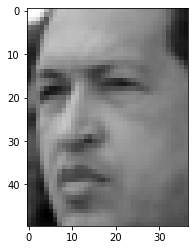

In [14]:
# datos tipo pandas
Xdata = pd.DataFrame(lfw_people.data)
y = lfw_people.target
print('Dimensiones tipo pandas: ',Xdata.shape)
plt.imshow(np.array(Xdata.iloc[0,:]).reshape(lfw_people.images.shape[1],lfw_people.images.shape[2]),cmap='gray')


In [15]:
#Paso 2: Particion entrenamiento y validacion
# Tamaño Xtrain 70%, Tamaño Xtest 30%
Xtrain, Xtest, ytrain,ytest = train_test_split(Xdata,y,test_size=0.3) #fijar en 0.3 para entrenar -- 0.95 para demostrar funcionalidad del código

Xtrain.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1810,1811,1812,1813,1814,1815,1816,1817,1818,1819,1820,1821,1822,1823,1824,1825,1826,1827,1828,1829,1830,1831,1832,1833,1834,1835,1836,1837,1838,1839,1840,1841,1842,1843,1844,1845,1846,1847,1848,1849
1032,84.000000,74.000000,66.333336,86.000000,112.333336,120.666664,122.666664,125.333336,128.666672,132.666672,134.000000,138.333328,145.000000,152.000000,157.333328,164.000000,171.333328,178.000000,177.000000,174.000000,171.666672,171.000000,170.000000,164.666672,160.000000,156.666672,154.333328,150.000000,142.666672,133.333328,127.333336,121.666664,117.333336,104.333336,78.000000,51.000000,62.000000,83.333336,68.333336,68.000000,...,212.000000,223.666672,226.333328,55.000000,145.333328,192.000000,195.666672,197.666672,200.333328,199.000000,172.666672,125.333336,96.000000,82.333336,80.333336,91.666664,98.333336,102.000000,110.000000,111.000000,121.333336,123.000000,119.666664,126.333336,131.333328,120.000000,112.000000,104.666664,96.000000,78.333336,76.333336,78.000000,103.666664,117.333336,38.333332,37.000000,149.000000,218.666672,226.000000,226.333328
997,84.666664,98.000000,100.000000,120.000000,132.666672,132.000000,139.000000,151.666672,160.000000,164.000000,175.666672,187.000000,191.000000,189.666672,192.000000,194.666672,197.000000,204.000000,204.333328,204.333328,203.000000,199.666672,202.333328,207.000000,204.333328,203.333328,200.333328,196.666672,195.666672,188.333328,184.333328,179.333328,175.666672,176.666672,154.666672,108.666664,102.000000,86.666664,102.333336,107.000000,...,151.333328,32.333332,25.000000,11.333333,9.000000,26.666666,125.000000,166.333328,170.666672,149.333328,97.666664,79.333336,91.666664,117.333336,122.666664,128.666672,140.333328,155.000000,166.333328,169.000000,168.666672,177.000000,181.333328,181.666672,183.666672,180.333328,164.666672,135.000000,131.666672,147.666672,144.333328,123.333336,144.000000,199.000000,215.333328,209.666672,211.000000,139.333328,32.000000,26.666666
644,46.000000,31.000000,18.333334,20.000000,42.333332,73.333336,98.666664,125.000000,147.666672,165.333328,178.666672,190.000000,198.333328,197.333328,194.000000,196.000000,197.000000,201.333328,204.333328,198.333328,190.333328,188.666672,189.333328,187.666672,182.000000,175.000000,175.000000,165.333328,160.000000,157.333328,140.333328,129.000000,116.333336,81.333336,33.666668,15.666667,20.666666,47.000000,24.666666,18.333334,...,103.666664,123.666664,126.000000,33.666668,32.000000,30.333334,29.333334,27.000000,23.000000,18.333334,7.000000,5.666667,18.333334,30.333334,29.333334,23.666666,32.666668,44.333332,49.666668,46.666668,40.666668,40.000000,40.666668,49.000000,56.333332,56.666668,56.000000,60.333332,66.000000,72.333336,73.666664,78.333336,75.333336,68.666664,74.000000,83.000000,88.666664,102.333336,124.333336,127.000000
744,12.000000,29.333334,74.000000,102.000000,108.666664,90.333336,81.000000,142.333328,179.666672,172.333328,146.666672,133.000000,134.333328,137.666672,144.666672,152.333328,157.666672,159.666672,163.000000,166.666672,167.333328,169.000000,169.333328,167.333328,167.666672,168.000000,167.000000,164.333328,160.666672,153.666672,153.000000,152.000000,150.000000,149.666672,152.000000,140.000000,107.333336,18.000000,41.666668,89.333336,...,199.000000,227.000000,215.000000,10.666667,11.333333,13.000000,12.333333,16.333334,22.666666,22.000000,74.666664,126.333336,70.666664,31.000000,26.000000,32.333332,43.000000,52.333332,63.666668,73.000000,76.333336,81.666664,87.666664,98.000000,102.333336,104.000000,107.666664,106.666664,103.666664,105.333336,108.333336,110.000000,111.666664,116.000000,129.000000,136.333328,184.666672,230.666672,225.666672,215.333328
1137,54.666668,58.333332,85.333336,137.333328,165.000000,179.000000,186.666672,189.000000,192.333328,196.333328,200.666672,204.000000,203.000000,201.333328,200.666672,199.000000,196.000000,199.000000,200.000000,201.000000,202.000000,202.000000,20

[t-SNE] Computing 70 nearest neighbors...
[t-SNE] Indexed 901 samples in 0.047s...
[t-SNE] Computed neighbors for 901 samples in 3.015s...
[t-SNE] Computed conditional probabilities for sample 901 / 901
[t-SNE] Mean sigma: 15.190723
[t-SNE] Computed conditional probabilities in 0.048s
[t-SNE] Iteration 50: error = 74.1072083, gradient norm = 0.3496323 (50 iterations in 0.404s)
[t-SNE] Iteration 100: error = 74.7000656, gradient norm = 0.3384177 (50 iterations in 0.396s)
[t-SNE] Iteration 150: error = 75.4631500, gradient norm = 0.3335970 (50 iterations in 0.399s)
[t-SNE] Iteration 200: error = 74.5658264, gradient norm = 0.3471963 (50 iterations in 0.385s)
[t-SNE] Iteration 250: error = 73.6032944, gradient norm = 0.3394863 (50 iterations in 0.377s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.603294
[t-SNE] KL divergence after 251 iterations: 1797693134862315708145274237317043567980705675258449965989174768031572607800285387605895586327668781715404589535143824

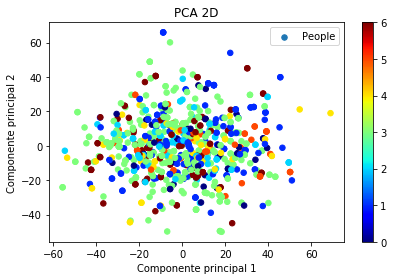

Guardando... relevancia_PCA_eigenface


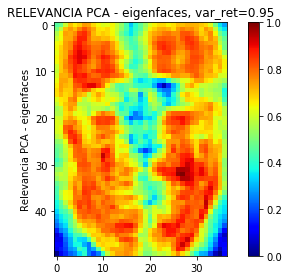

Guardando... tsne_2D


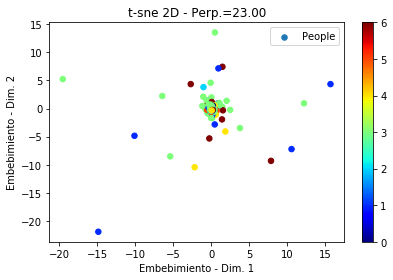

True

In [16]:
#%% Paso 3 : Analisis exploratorio
#preproceso entrada  y salida para analisis exploratorio
img_path = '' #para guardar from google.colab import files plt.savefig("abc.png") files.download("abc.png") 
pre_exploratorio(Xtrain,ytrain,img_path,'People',lfw_people.images.shape[1],lfw_people.images.shape[2])

In [0]:
#%% Paso 4 : Escoger modelo por gridsearchCV utilizando pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.externals import joblib #https://joblib.readthedocs.io/en/latest/

steps=[[('rep',  PCA()),
        ('cla', LogisticRegression())],
       [('rep',  PCA()),
        ('cla', SGDClassifier())],
        [('cla', SVC())]
       #[('rep',  PCA()),
       # ('cla', SVC())]
      ]
parameters = [{
              'rep__n_components' : [0.8,0.9],              
              'cla__C': [0.5,1],
              },
              {
              'rep__n_components' : [0.8,0.9],              
              'cla__alpha': [0.0001,0.001],
              },
              {
             #'rep__n_components' : [0.8,0.9],              
             'cla__C': [0.1,1,100,500,1e3],
             'cla__gamma': [0.01, 0.1, 1,10, 100,1e3]     
             }
             ]

label_models = ['PCA_Logistic','PCA_SGD', 'SVCrbf']

best_model = []
filename = ''#'resultados/people_comp'
for i in range(len(steps)):
    print('modelo %d/%d' % (i+1,len(steps)))
    grid_search = GridSearchCV(Pipeline(steps[i]), parameters[i], n_jobs=-1,cv=5,
                                scoring='balanced_accuracy',verbose=10)
    grid_search.fit(Xtrain, ytrain)
    #print(grid_search.cv_results_)
    #mejor modelo entrenado
    best_model += [grid_search.best_estimator_]
    joblib.dump(best_model,filename+".pkl")

print('Mejores modelos:\n')
best_model

# Calcular rendimiento en cojunto de test

In [0]:
#%% Paso 5: evaluar sobre Xtest
my_model_loaded = joblib.load(filename+".pkl")
path_img = ''
for i in range(len(my_model_loaded)):
    print('Evaluando modelo %d/%d' % (i+1,len(my_model_loaded)))

    ytest_e = my_model_loaded[i].predict(Xtest)
    acc = accuracy_score(ytest,ytest_e)
     
    plot_confusion_matrix(
                          ytest, ytest_e, 
                          classes=lfw_people.target_names,
                          normalize=True,
                          title='ACC = %.1f %%' % (100*acc)
                          )
    plt.autoscale()
    save_fig(path_img,label_models[i])                      
    plt.show()
    
    cr = classification_report(
                               ytest, ytest_e, 
                               labels=range(lfw_people.target_names.shape[0]),
                               target_names=lfw_people.target_names
                               )                          
    #support = #muestras en la clase estudiada
    print(cr)


## Curva ROC multiclase - sobre conjunto de test

In [0]:
from sklearn.preprocessing import label_binarize

ytrain_b = label_binarize(ytrain, classes=range(lfw_people.target_names.shape[0]))
ytest_b = label_binarize(ytest, classes=range(lfw_people.target_names.shape[0]))

for i in range(len(my_model_loaded)):
    print('Evaluando ROC modelo %d/%d' % (i+1,len(my_model_loaded)))
    ytest_score = my_model_loaded[i].decision_function(Xtest) #debe calcularse la funcion de decision o el posterior de la probabilidad
    roc_auc, fpr, tpr, n_classes = roc_multiclass(ytest_b,ytest_score)
    roc_auc_mc(roc_auc,fpr,tpr,n_classes,'ROC curve ' + label_models[i],path_img)
    